In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]

#target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')



In [2]:
from numrisk.utils.data import get_data_majduge

df = get_data_majduge()

number of subjects found: 66


In [3]:
from utils import get_decoding_info

pred = []
for sub in subjects:
    pred.append(get_decoding_info(sub,bids_folder=bids_folder))

pred = pd.concat(pred).join(df, how='inner')

/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-65/func/sub-65_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-66/func/sub-66_ses-1_mask-NPC_R_space-T1w_pars.tsv


In [5]:
import pingouin as pg

r = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d['log(n1)']))

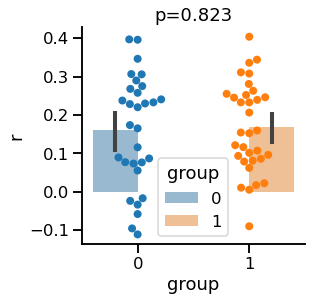

In [14]:
temp = r.groupby(['subject','group']).mean()
sns.set_context('talk')

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
#sns.move_legend(ax, "outside")
sns.despine()

In [21]:
target_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

r.reset_index(['group', None])[['r']].to_csv(op.join(target_folder,'decoding_r.csv'))

In [20]:
r.reset_index(['group', None])

,group,level_2,n,r,CI95%,p-val,BF10,power
subject,,,,,,,,
1,0,pearson,180,-0.058083,"[-0.2, 0.09]",0.438643,0.126,0.121123
2,1,pearson,173,0.206071,"[0.06, 0.34]",0.006527,3.727,0.780216
4,1,pearson,178,-0.089840,"[-0.23, 0.06]",0.233035,0.19,0.222729
5,0,pearson,179,-0.023735,"[-0.17, 0.12]",0.752483,0.098,0.061401
6,1,pearson,180,0.062036,"[-0.08, 0.21]",0.408064,0.131,0.131454
...,...,...,...,...,...,...,...,...
60,0,pearson,180,0.229764,"[0.09, 0.36]",0.001917,11.045,0.877014
61,0,pearson,179,-0.095490,"[-0.24, 0.05]",0.203541,0.209,0.246814
62,0,pearson,179,0.305624,"[0.17, 0.43]",0.000032,499.349,0.987423
